<a href="https://colab.research.google.com/github/eduardovitor22/Banner/blob/main/sele%C3%A7%C3%A3o_de_recursos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preço da casa: regressão empilhada (3%)



In [ ]:
#importar os pacotes necessarios
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline  

from scipy import stats
from sklearn import preprocessing
from sklearn import feature_selection
import warnings
warnings.filterwarnings('ignore')
SEED = 42

In [ ]:
#importando arquivo para um dataframe
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:1459], all_data.loc[1460:]

df_train = pd.read_csv('/content/train.csv')
y_train = df_train.SalePrice
id_val = df_train.Id
df_test = pd.read_csv('/content/test.csv')
df_all = concat_df(df_train, df_test).drop(['SalePrice', 'Id'], axis=1)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print(f'Number of Training Examples = {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}\n')
print(f'Training X Shape = {df_train.shape}')
print(f'Training y Shape = {df_train["SalePrice"].shape[0]}\n')
print(f'Test X Shape = {df_test.shape}')
print(f'Test y Shape = {df_test.shape[0]}\n')
print(df_train.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 81)
Training y Shape = 1460

Test X Shape = (1459, 80)
Test y Shape = 1459

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 

In [ ]:
#Abrindo as 5 primeiras linhas
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


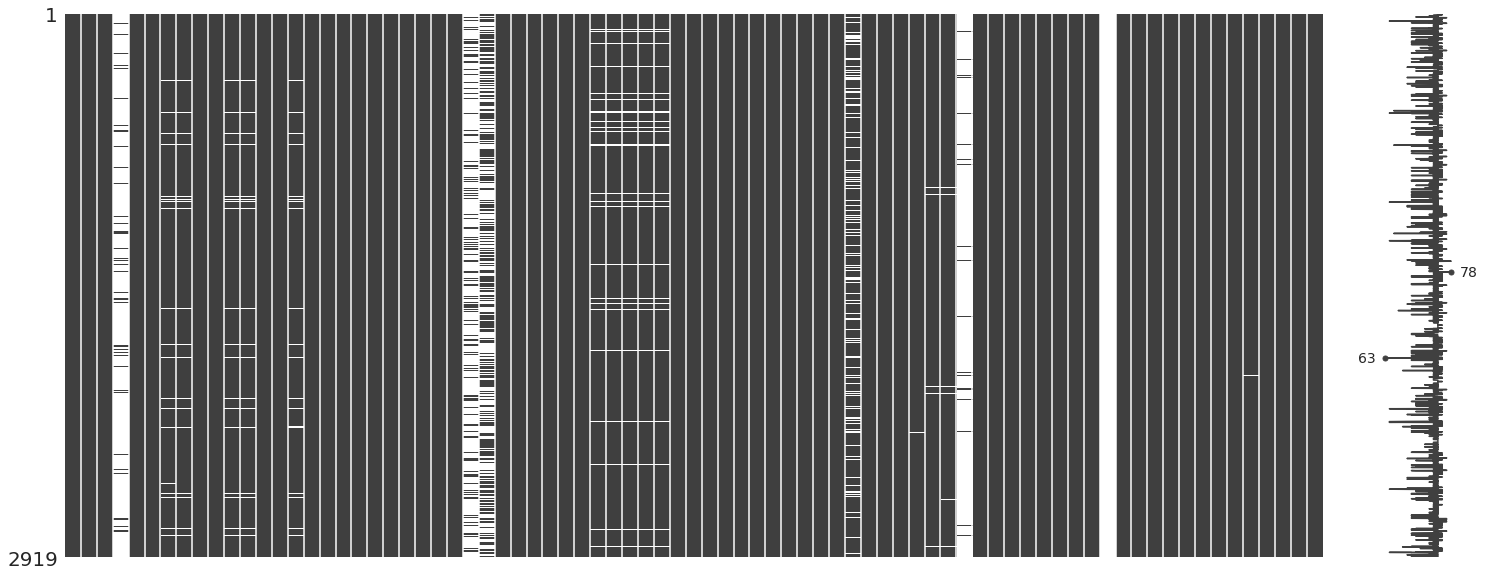

In [ ]:
# Visualize os valores gerais ausentes dos dados
msno.matrix(df_all)
plt.show()

In [ ]:
for df in dfs:
    print(f'Only features contained missing value in {df.name}')
    temp = df.isnull().sum()
    print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Set
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64 

Only features contained missing value in Test Set
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76



*   Para recursos com valor ausente menor que 100 -> preencherei recursos numéricos com as características medianas e categóricas correspondentes com os valores correspondentes mais frequentes
*  Para recursos com valor ausente maior que 1000 -> Remover esses recursos pode ser uma boa escolha
*   Para outros recursos com valor ausente -> vou preenchê-los com o valor "Null" (b.c todos os outros recursos são recursos de objeto)





In [ ]:
null_features = df_all.isnull().sum()

# Para recursos com menos de 100 valores ausentes
null_100 = df_all.columns[list((null_features < 100) & (null_features != 0))]
num = df_all[null_100].select_dtypes(include=np.number).columns
non_num = df_all[null_100].select_dtypes(include='object').columns
# Vários recursos
df_all[num] = df_all[num].apply(lambda x: x.fillna(x.median()))
# Recursos do objeto
df_all[non_num] = df_all[non_num].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Para recursos com mais de 1.000 valores ausentes
null_1000 = df_all.columns[list(null_features > 1000)]
df_all.drop(null_1000, axis=1, inplace=True)
df_all.drop(['GarageYrBlt', 'LotFrontage'], axis=1, inplace=True)

In [ ]:
# Para outros recursos com valores ausentes
df_all['GarageCond'] = df_all['GarageCond'].fillna('Null')
df_all['GarageFinish'] = df_all['GarageFinish'].fillna('Null')
df_all['GarageQual'] = df_all['GarageQual'].fillna('Null')
df_all['GarageType'] = df_all['GarageType'].fillna('Null')

In [ ]:
# Atualizar dados de treinamento e teste
df_train, df_test = divide_df(df_all)
df_train = pd.concat([df_train, y_train], axis=1)

# Verificando o valor ausente existente ou não
print('If the result is zero means not exist any missing values in dataset')
print(df_all.isnull().any().sum())

If the result is zero means not exist any missing values in dataset
0


In [ ]:
# Vendo a correlação entre recursos e destino
df_train_corr = df_train.corr()['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])
df_train_corr.head(10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

###Visualize os 16 recursos que têm a maior correlação com o destino

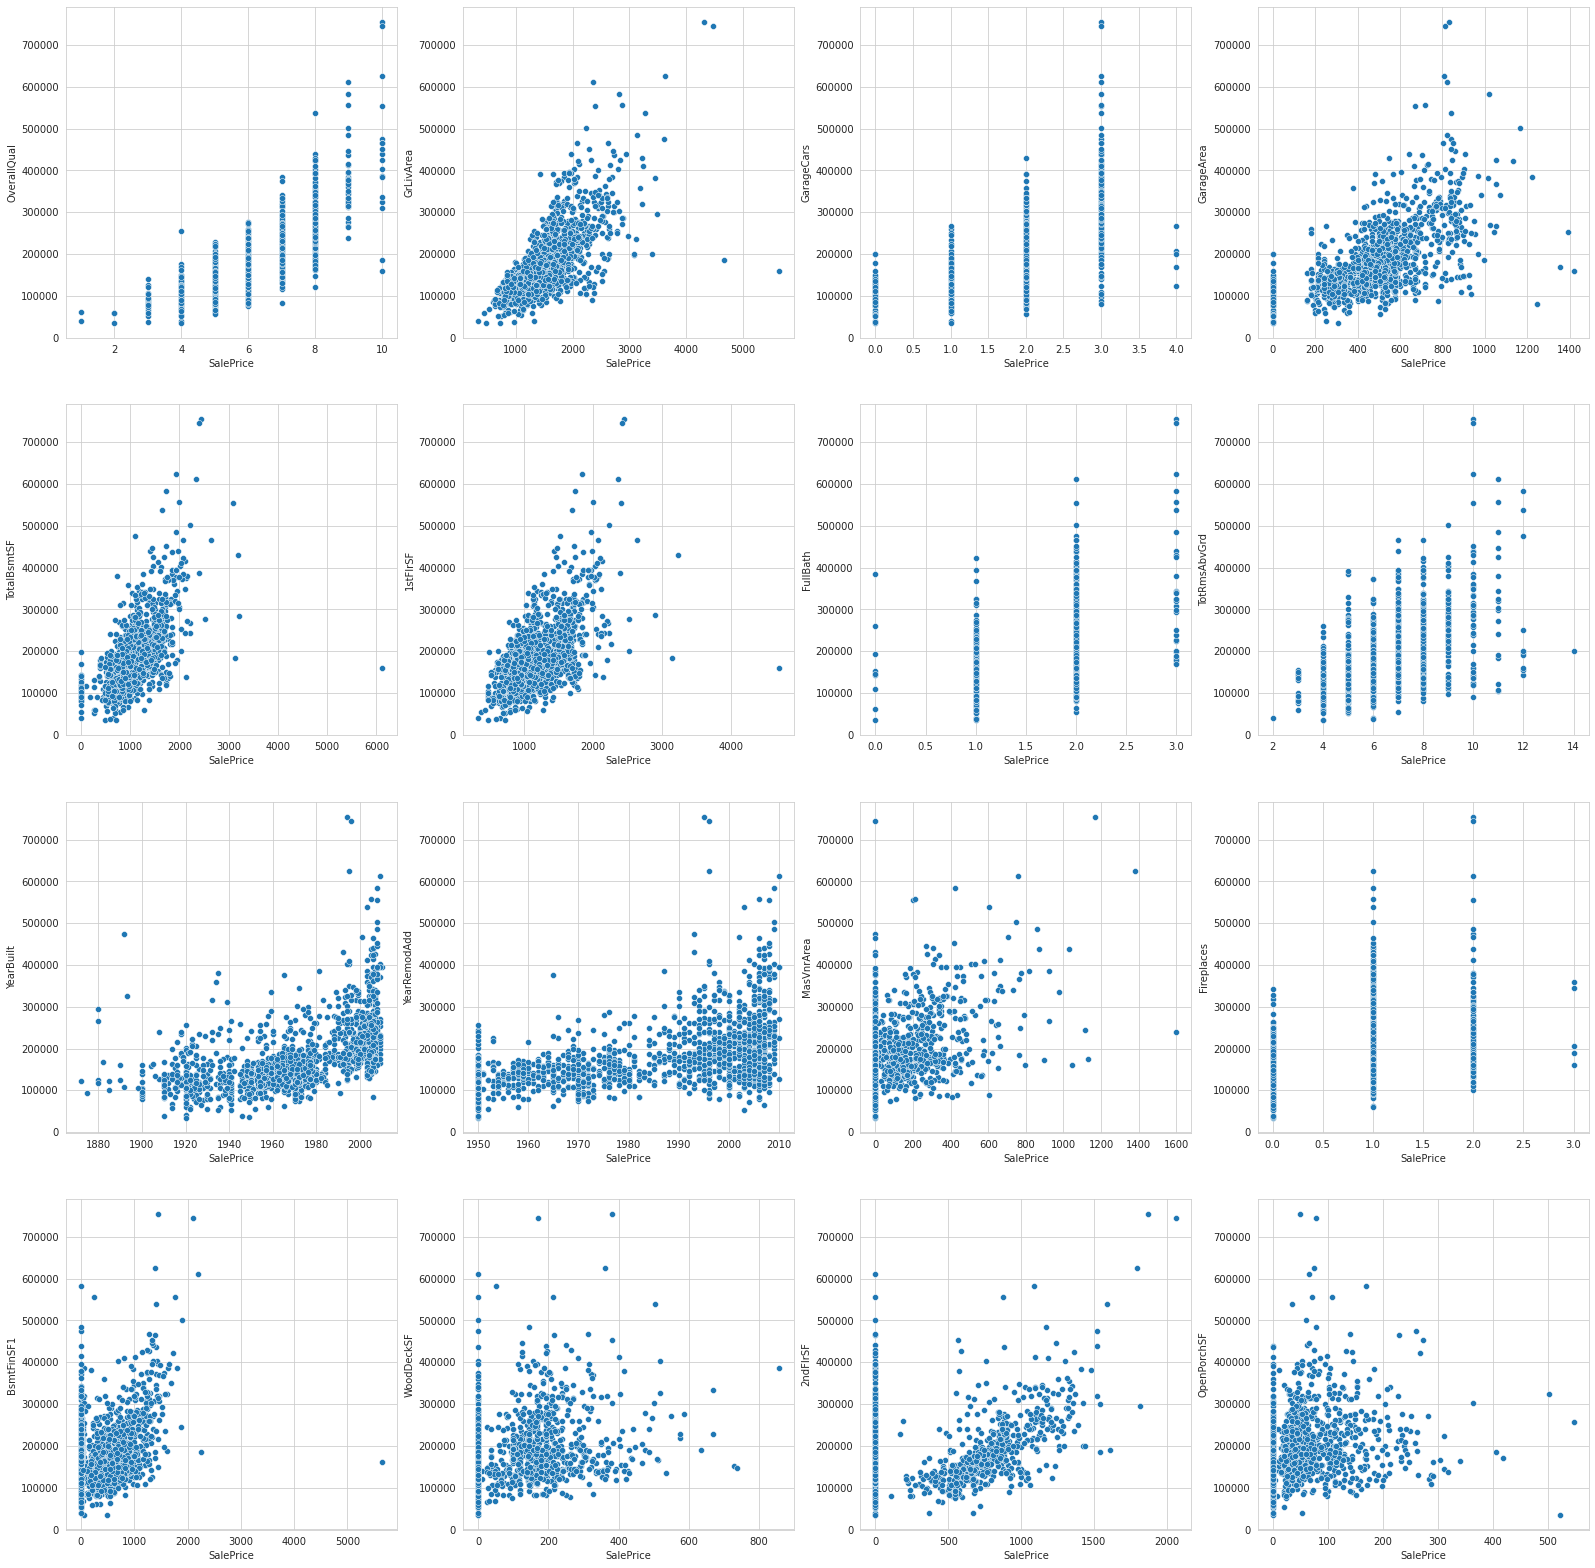

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(18, 18))
plt.subplots_adjust(right=1.3, top=1.3)
axs = axs.flatten()
for i, col in enumerate(list(df_train_corr.index[:16])):
    sns.scatterplot(y='SalePrice', x=col, ax=axs[i], data=df_train)
    axs[i].set_xlabel('SalePrice')
    axs[i].set_ylabel(col)
plt.show()

###OverallQual é um recurso categórico. Portanto, o box plot deve ser adequado neste caso para mostrar claramente a característica de alta correlação entre a qualidade geral ("OverallQual") da casa com o seu preço ("SalePrice").

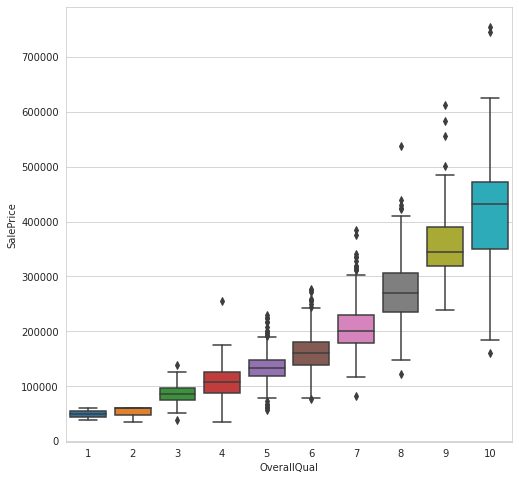

In [ ]:
# Corr de "OverallQual": 0.7909
fig = plt.figure(figsize=(8, 8))
sns.boxplot(df_train['OverallQual'], df_train['SalePrice'])
plt.show()

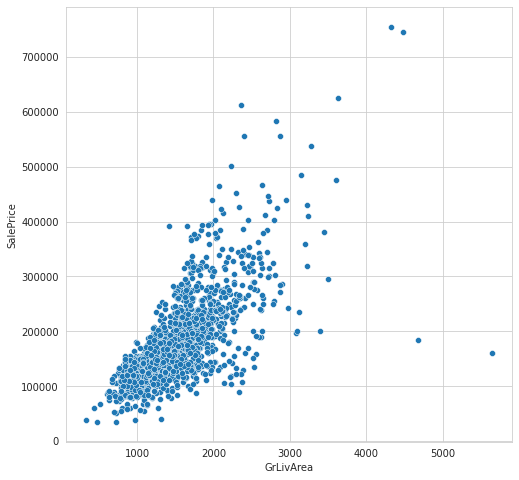

In [ ]:
# Corr de "GrLivArea": 0.708
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(df_train['GrLivArea'], df_train['SalePrice'])
plt.show()

In [ ]:
#Detectando conjuntos
df_train_cate = df_train.select_dtypes(include=['object', 'category'])
df_train_cate.head()

,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,SBrkr,...,RL,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,TA,Mn,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
3,1Fam,Gd,No,ALQ,Unf,TA,Y,Norm,Norm,SBrkr,...,RL,None,Crawfor,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub
4,1Fam,TA,Av,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,NoRidge,Y,CompShg,Gable,Normal,WD,Pave,AllPub


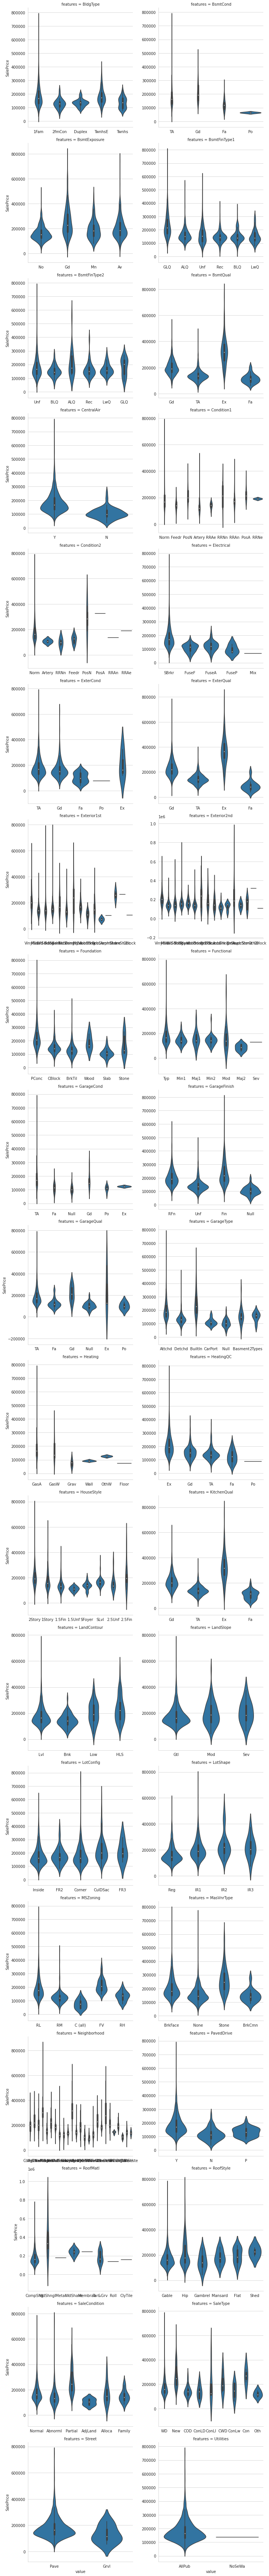

In [ ]:
#relação entre os recursos categóricos e o recurso de destino
data = pd.melt(pd.concat([df_train_cate, y_train], axis=1),
               id_vars=['SalePrice'], value_vars=df_train_cate.columns, var_name='features')
g = sns.FacetGrid(data, col='features', col_wrap=2, sharex=False, sharey=False, size=5)
g.map(sns.violinplot, 'value', 'SalePrice')

In [ ]:
# Existem alguns recursos com média menor que 1
df_train.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,3.409589,2.866438,443.639726,46.549315,0.425342,0.057534,567.240411,21.954110,...,6.099315,2.758904,15.060959,6.517808,1057.429452,94.244521,1971.267808,1984.865753,2007.815753,180921.195890
std,386.587738,436.528436,29.317331,0.815778,456.098091,161.319273,0.518911,0.238753,441.866955,61.119149,...,1.382997,40.177307,55.757415,1.625393,438.705324,125.338794,30.202904,20.645407,1.328095,79442.502883
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000,34900.000000
25%,882.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,223.000000,0.000000,...,5.000000,0.000000,0.000000,5.000000,795.750000,0.000000,1954.000000,1967.000000,2007.000000,129975.000000
50%,1087.000000,0.000000,0.000000,3.000000,383.500000,0.000000,0.000000,0.000000,477.500000,0.000000,...,6.000000,0.000000,0.000000,6.000000,991.500000,0.000000,1973.000000,1994.000000,2008.000000,163000.000000
75%,1391.250000,728.000000,0.000000,3.000000,712.250000,0.000000,1.000000,0.000000,808.000000,0.000000,...,7.000000,0.000000,0.000000,7.000000,1298.250000,168.000000,2000.000000,2004.000000,2009.000000,214000.000000
max,4692.000000,2065.000000,508.000000,8.000000,5644.000000,1474.000000,3.000000,2.000000,2336.000000,552.000000,...,10.000000,738.000000,480.000000,14.000000,6110.000000,857.000000,2010.000000,2010.000000,2010.000000,755000.000000


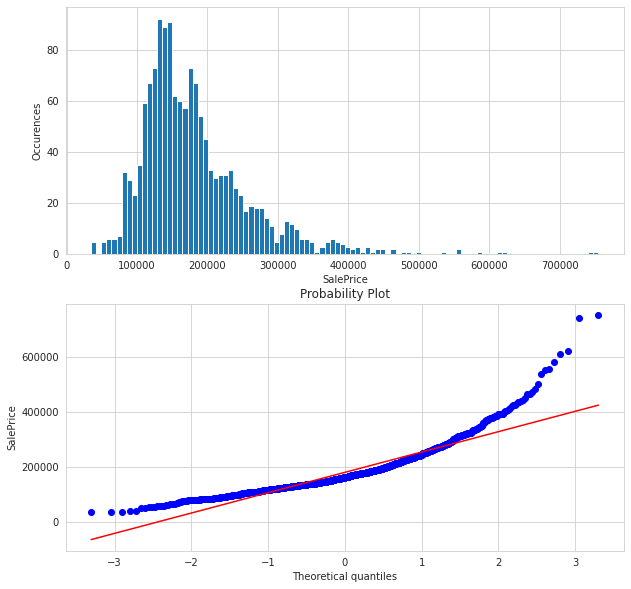

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
y_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Occurences')
ax1.set_xlabel('SalePrice')

stats.probplot(y_train, dist=stats.norm, plot=ax2)
ax2.set_ylabel('SalePrice')
plt.show()

O recurso de destino é uma distribuição de Box-Cox --> Então a transformação Box-Cox deve ser útil para trazer o destino da distribuição de cauda pesada para a normal

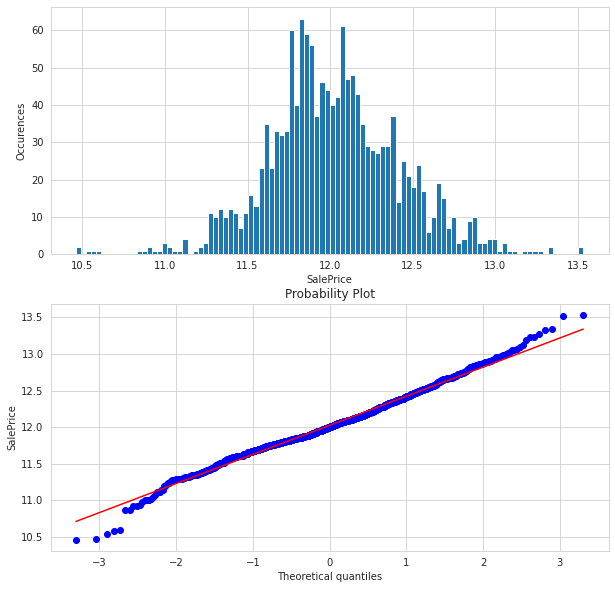

In [ ]:
# Usando a transformação Box-Cox no recurso de destino
org_y_train = y_train
y_train = pd.Series(stats.boxcox(y_train, lmbda=0), name='SalePrice')

# Visualize o alvo após a transformação box-cox
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
y_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Occurences')
ax1.set_xlabel('SalePrice')

stats.probplot(y_train, dist=stats.norm, plot=ax2)
ax2.set_ylabel('SalePrice')
plt.show()

#Distorção

É o grau de distorção da curva normal simétrica --> A distorção da distribuição normal é "0"
A assimetria positiva significa que a cauda do lado direito da distribuição é mais longa e mais gorda
A assimetria negativa significa que a cauda do lado esquerdo da distribuição é mais longa e mais gorda
Curtose

Na teoria da probabilidade e estatística, a Curtose é a medida de valores extremos (outliers) apresentados na distribuição

In [ ]:
# Compute Skewness & Kurtosis
print(f'Skewness before transformation: {stats.skew(org_y_train)}')
print(f'Kurtosis before transformation: {stats.kurtosis(org_y_train)}\n')

print(f'Skewness after transformation: {stats.skew(y_train)}')
print(f'Kurtosis after transformation: {stats.kurtosis(y_train)}')

Skewness before transformation: 1.880940746034036
Kurtosis before transformation: 6.509812011089439

Skewness after transformation: 0.1212103673013655
Kurtosis after transformation: 0.8026555069117713


###Binning de recursos contínuos
Usando a técnica "Bin" para todos os recursos que representam o valor "year" (Ex: 2000, 1999,...)
E depois disso, codificando-os em recursos contínuos

In [ ]:
# Usando a técnica binned para "YearBuilt", "YearRemodAdd" e "YrSold"
df_all['YearBuilt'] = pd.qcut(df_all['YearBuilt'], 10, duplicates='drop')
df_all['YearRemodAdd'] = pd.qcut(df_all['YearRemodAdd'], 10, duplicates='drop')
df_all['YrSold'] = pd.qcut(df_all['YrSold'], 10, duplicates='drop')

In [ ]:
# Codifique recursos categóricos para recursos numéricos
for cate_col in ['YearBuilt', 'YearRemodAdd', 'YrSold']:
    df_all[cate_col] = preprocessing.LabelEncoder().fit_transform(df_all[cate_col].values)

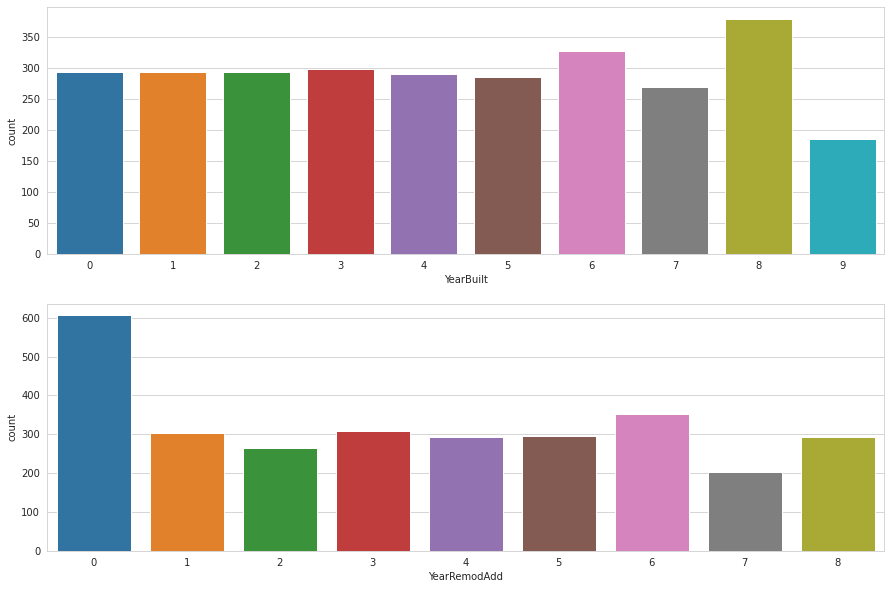

In [ ]:
#visualizaremos os recursos do ano após aplicar a técnica de binning
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
sns.countplot(df_all['YearBuilt'], ax=axs[0])
sns.countplot(df_all['YearRemodAdd'], ax=axs[1])
plt.show()

In [ ]:
#Transformando recursos numéricos que são categoricos
df_all['MSSubClass'] = df_all['MSSubClass'].astype(str)
df_all['OverallCond'] = df_all['OverallCond'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

In [ ]:
# Gerando novos recursos
# Total de pés quadrados
df_all['TotalSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

# Número total de bathroom
df_all['TotalBath'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                               df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))
df_all['TotalBsmtbath'] = df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath'])

# Total de metros quadrados de varanda em uma casa
df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                            df_all['EnclosedPorch'] + df_all['ScreenPorch'] + df_all['WoodDeckSF'])

# Verificar a existência de cada infraestrutura (Ex: cave, banho,...) em uma casa
df_all['IsRemodel'] = df_all[['YearBuilt', 'YearRemodAdd']].apply(lambda x: 1 if x[0] != x[1] else 0, axis=1)
df_all['HasPool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['Has2ndFloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasGarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasBsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasFireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Elimine todos os recursos da receita
remove_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'FullBath', 'HalfBath', 'BsmtFullBath',
              'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']
df_all.drop(remove_cols, axis=1, inplace=True)


In [ ]:
# Lista de recursos categóricos
cate_features = list(df_all.select_dtypes(include=['object', 'category']).columns)

# Lista de recursos numéricos
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = list(df_all.select_dtypes(include=numeric_dtypes).columns)

In [ ]:
# Atualize o conjunto de dados de treinamento e teste
df_train, df_test = divide_df(df_all)

In [ ]:
def forward_feature_selection(df_train, cate_features):
    '''Activate the "forward feature selection" technique to select the most appropriate features
    Arg:
        cate_features: list of string names of all categorical features in dataset
    Return:
        SFS object
        '''
    # df preparado para entrada na técnica
    pre_ffs = pd.DataFrame(columns=cate_features)

    # Codifique recursos categóricos para recursos numéricos para utilizar o "recurso de seleção direta"
    for cate_col in cate_features:
        pre_ffs[cate_col] = preprocessing.LabelEncoder().fit_transform(df_train[cate_col].values)
        
    # Avançar na seleção de recursos
    sfs1 = SFS(RandomForestRegressor(),
               k_features=2,
               forward=True,
               floating=False,
               verbose=2,
               scoring='r2',
               cv=3)
    
    sfs1 = sfs1.fit(np.array(pre_ffs[cate_features]), np.array(y_train))
    return sfs1


In [ ]:
cate_features =  ['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
 'ExterCond', 'ExterQual', 'Exterior2nd', 'Functional', 'GarageCond', 'GarageType', 'Heating', 'HouseStyle', 'KitchenQual',
 'LandContour', 'LandSlope', 'LotShape', 'MSSubClass', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle',
 'SaleCondition', 'SaleType', 'Street', 'Utilities']

Valor incompatível entre o conjunto de treinamento e teste em recursos categóricos
Em alguns casos, algumas colunas no conjunto de dados de trem continham valores que não existem no conjunto de dados de teste, nós os chamamos de dados incompatíveis entre o trem e o teste

In [ ]:
# "Electrical" é um exemplo de valores de recursos incompatíveis
print('In training dataset\n', df_train['Electrical'].value_counts(), '\n')
print('In testing dataset\n', df_test['Electrical'].value_counts())

In training dataset
 SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64 

In testing dataset
 SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


In [ ]:
cate_mismatch = list()

# Determina os recursos que continham valores incompatíveis
for cate_col in cate_features:
    train_cate = df_train[cate_col].value_counts().index
    test_cate = df_test[cate_col].value_counts().index
    check_len = len(np.setdiff1d(train_cate, test_cate)) + len(np.setdiff1d(test_cate, train_cate))
    if check_len != 0:
        cate_mismatch.append(cate_col)
        
print('List of mismatched value features: \n', cate_mismatch)

List of mismatched value features: 
 ['Condition2', 'Electrical', 'Exterior2nd', 'Heating', 'HouseStyle', 'MSSubClass', 'RoofMatl', 'Utilities']




*   Para lidar com valores incompatíveis, vou substituí-los pelos valores com maior frequência em cada recurso.
*   Com alguns recursos com grande número de valores diferentes, acho que removê-los pode ser uma boa escolha



In [ ]:
# "Electrical" recursos
df_train['Electrical'].loc[df_train['Electrical']=='Mix'] = 'SBrkr'

# "Exterior2nd" recursos
df_train['Exterior2nd'].loc[df_train['Exterior2nd']=='Other'] = 'VinylSd'

# "Heating" recursos
df_train['Heating'].loc[df_train['Heating']=='OthW'] = 'GasA'
df_train['Heating'].loc[df_train['Heating']=='Floor'] = 'GasA'

# "HouseStyle" recursos
df_train['HouseStyle'].loc[df_train['HouseStyle']=='2.5Fin'] = '1.5Fin'

# "MSSubClass" recursos
df_test['MSSubClass'].loc[df_test['MSSubClass']=='150'] = '160'

# "Condition2" recursos
temp = [True if ((val=='RRNn') | (val=='RRAn') | (val=='RRAe')) else False
        for val in df_train['Condition2']]
df_train['Condition2'].loc[temp] = 'Norm'

# "Utilities" é um recurso de valor constante --> Excluir
# "RoofMatl" tem um número alto de valores diferentes --> Excluir
cate_drop = ['Utilities', 'RoofMatl']
df_train.drop(cate_drop, axis=1, inplace=True)
df_test.drop(cate_drop, axis=1, inplace=True)

# Atualize a lista cate_features também
cate_features = [col for col in cate_features if col not in cate_drop]

In [ ]:
# Checando "Condition2" recurso
print('In training dataset\n', df_train['Electrical'].value_counts(), '\n')
print('In testing dataset\n', df_test['Electrical'].value_counts())

In training dataset
 SBrkr    1336
FuseA      94
FuseF      27
FuseP       3
Name: Electrical, dtype: int64 

In testing dataset
 SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


In [ ]:
# Encontre a correlação do recurso com o alvo usando o coeficiente de Pearson
pearson = dict()
for col in num_features:
    pear_val = stats.pearsonr(np.array(df_train[col]), np.array(y_train))[0]
    pearson[col] = pear_val
    
pearson = pd.Series(pearson).abs().sort_values(ascending=False)
# Escolha apenas o recurso com correlação maior que 0,2
num_features = list(pearson.loc[pearson > 0.2].index)
num_features

['OverallQual',
 'GrLivArea',
 'TotalSF',
 'GarageCars',
 'TotalBath',
 'GarageArea',
 'YearBuilt',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'HasFireplace',
 'Fireplaces',
 'MasVnrArea',
 'TotalPorchSF',
 'HasGarage',
 '2ndFlrSF',
 'LotArea',
 'TotalBsmtbath',
 'BsmtUnfSF',
 'BedroomAbvGr']

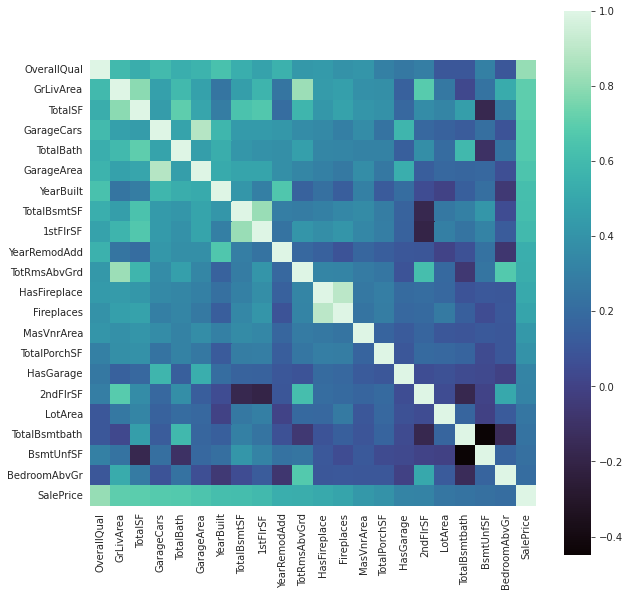

In [ ]:
chosen_cols = num_features + cate_features

# Visualizando a tabela de correlação
fig = plt.figure(figsize=(10, 10))
sns.heatmap(pd.concat([df_train[chosen_cols], y_train], axis=1).corr(), square=True,
            cmap='mako', annot_kws={'size': 14})

In [ ]:
df_train = df_train[chosen_cols]
df_test = df_test[chosen_cols]
df_all = concat_df(df_train, df_test)

 Recursos numéricos altamente distorcidos
Recursos numéricos altamente distorcidos são os recursos de Box-Cox, como nossos recursos de destino
Decidimos se um recurso é assimétrico ou não com base no valor da medição estatística de "assimetria"
Todos os recursos distorcidos serão normalizados pela técnica de normalização Box-cox

In [ ]:
# Normalize o recurso de assimetria usando a função Log
skew_features = df_all[num_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features = skew_features[abs(skew_features) > 0.75]
print(skew_features)           

# Aplicar Box cox para assimetria > 0,75
for feat in skew_features.index:
    df_all[feat] = np.log1p(df_all[feat])

LotArea         12.822431
MasVnrArea       2.613592
TotalSF          1.835745
1stFlrSF         1.469604
TotalPorchSF     1.376649
GrLivArea        1.269358
TotalBsmtSF      1.162616
BsmtUnfSF        0.919703
2ndFlrSF         0.861675
TotRmsAbvGrd     0.758367
HasGarage       -3.955907
dtype: float64


In [ ]:
df_train, df_test = divide_df(df_all)

 codificando os recursos numéricos para serem inseridos com sucesso no modelo pela técnica de "codificação one-hot".

In [ ]:
print(df_train.shape, df_test.shape)

(1460, 48) (1459, 48)


In [ ]:
# Transforme recursos categóricos em recursos fictícios
encoded_features = list()

for df in [df_train, df_test]:
    for feature in cate_features:
        # Mude para array após a codificação b.c deseja adicionar colunas quando voltar para df
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        # "n": Número de valor único em cada recurso
        n = df[feature].nunique()
        # "feature_uniqueVal" são os nomes das colunas em df após a codificação One-hot
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
df_train = pd.concat([df_train, *encoded_features[:len(cate_features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(cate_features):]], axis=1)

remover os originais para evitar treinar o mesmo tipo de informação. 
Como os recursos categóricos originais e sua versão de codificação one-hot representam a mesma informação

In [ ]:
# Solte os recursos da categoria original
df_train.drop(cate_features, axis=1, inplace=True)
df_test.drop(cate_features, axis=1, inplace=True)

df_all = concat_df(df_train, df_test)

In [ ]:
print(df_train.shape, df_test.shape)

(1460, 196) (1459, 196)


In [ ]:
# Abrindo as 5 primeiras linhas do CSV
df_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtUnfSF,Fireplaces,GarageArea,GarageCars,GrLivArea,HasFireplace,HasGarage,...,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleType_9,Street_1,Street_2
0,6.753438,6.751101,3,5.017280,0,548.0,2.0,7.444833,0,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,7.141245,0.000000,3,5.652489,1,460.0,2.0,7.141245,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,6.825460,6.765039,3,6.075346,1,608.0,2.0,7.488294,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,6.869014,6.629363,3,6.293419,1,642.0,3.0,7.448916,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,7.044033,6.960348,4,6.196444,1,836.0,3.0,7.695758,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
# Modelando
from sklearn.model_selection import KFold # for repeated K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation
from sklearn.model_selection import cross_val_predict # prediction
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time
SEED = 42

In [ ]:
# Validação cruzada de dobras K repetidas
kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Retorna o erro quadrático médio da previsão do modelo (usado para previsão de teste)
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Retorna a validação cruzada aplicada ao erro quadrático médio (usado para previsão de treinamento)
def evaluate_model_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

##Contruindo alguns modelos


*   Ridge é um modelo de regressão que aplica a técnica de regularização l2.

*   Lasso significa Least Absolute Shrinkage and Selection Operator, que é um modelo de regressão linear aplicado à técnica de regularização l1

*   elasticnet é um modelo de regressão linear penalizado que inclui as penalidades L1 e L2 durante o treinamento

*   svr significa Support Vector Regression é um tipo de modelo "SVM" usado para problema de regressão

*   gbr é um modelo de aumento de gradiente para problema de regressão

*   lgbm é uma estrutura de aumento de gradiente rápida, distribuída e de alto desempenho que usa um algoritmo de aprendizado baseado em árvore

*   xgboost é um algoritmo de aprendizado de máquina baseado em árvore de decisão que usa uma estrutura de aumento de gradiente 




In [ ]:
def construct_models():
    # Initialize parameters for models
    alphas_ridge = [0.005, 0.01, 0.1, 1, 5, 10, 15]
    alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    e_alphas_elas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    e_l1ratio_elas = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
    
    # Contruindo modelos
    models = dict()
    
    models['ridge'] = RidgeCV(alphas=alphas_ridge, cv=kfolds)
    models['lasso'] = LassoCV(alphas=alphas_lasso, random_state=SEED, cv=kfolds)
    models['elasticnet'] = ElasticNetCV(alphas=e_alphas_elas, cv=kfolds, l1_ratio=e_l1ratio_elas)
    models['svr'] = SVR(C = 20, epsilon = 0.008, gamma =0.0003)
    models['gbr'] = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10, 
                                              loss='huber',random_state =SEED) 
    models['lgbm'] = LGBMRegressor(objective='regression', num_leaves=4,
                                   learning_rate=0.01, n_estimators=5000,
                                   max_bin=200, bagging_fraction=0.75,
                                   bagging_freq=5, bagging_seed=7,
                                   feature_fraction=0.2,
                                   feature_fraction_seed=7, verbose=-1,
                                  colsample_bytree=None, subsample=None, subsample_freq=None)
    models['xgboost'] = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7, verbosity = 0,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=SEED, reg_alpha=0.00006)
    return models

# Construir o conjunto de modelos
models = construct_models()

calculando o resultado do erro quadrático médio (rmse) para validar os modelos após o treinamento. o array numpy é recomendado como uma entrada para o modelo de treinamento em vez do Dataframe. Porque o numpy tem um grande benefício em relação ao consumo de tempo do que os pandas

In [ ]:
for name, model in models.items():
    #Começa a contar o tempo
    start = time.perf_counter()
    
    model = model.fit(np.array(df_train), np.array(y_train))
    rmse_result = rmse(y_train, model.predict(np.array(df_train)))
    print(f'{name}\'s rmse after training: {rmse_result}')
    
    # Calcula o tempo de execução de cada algo
    run = time.perf_counter() - start
    print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

ridge's rmse after training: 0.11872304460054577
Computational runtime of this algo: 2.05 seconds

lasso's rmse after training: 0.12077390109400547
Computational runtime of this algo: 0.75 seconds

elasticnet's rmse after training: 0.12038810145588953
Computational runtime of this algo: 2.28 seconds

svr's rmse after training: 0.09852269266178525
Computational runtime of this algo: 1.19 seconds

gbr's rmse after training: 0.05981278748723607
Computational runtime of this algo: 15.53 seconds

lgbm's rmse after training: 0.08973234976341637
Computational runtime of this algo: 1.56 seconds

xgboost's rmse after training: 0.058948603439429946
Computational runtime of this algo: 16.57 seconds



Computar rmse aplicando a técnica de validação cruzada para evitar o problema de "Overfitting"

In [ ]:
cv_rmse_result = dict()
cv_rmse_mean = dict()
cv_rmse_std = dict()

for name, model in models.items():
    # Começa a contar o tempo
    start = time.perf_counter()
    
    cv_rmse_result[name] = evaluate_model_cv(model, np.array(df_train), np.array(y_train))
    cv_rmse_mean[name] = cv_rmse_result[name].mean()
    cv_rmse_std[name] = cv_rmse_result[name].std()
    print(f'Finish {name}\'s model')
    
    # Calcula o tempo de execução de cada algo
    run = time.perf_counter() - start
    print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

Finish ridge's model
Computational runtime of this algo: 8.89 seconds

Finish lasso's model
Computational runtime of this algo: 4.2 seconds

Finish elasticnet's model
Computational runtime of this algo: 22.25 seconds

Finish svr's model
Computational runtime of this algo: 6.54 seconds

Finish gbr's model
Computational runtime of this algo: 165.38 seconds

Finish lgbm's model
Computational runtime of this algo: 12.55 seconds

Finish xgboost's model
Computational runtime of this algo: 151.12 seconds



In [ ]:
ML_cv = pd.DataFrame({'cv_rsme_mean' : cv_rmse_mean, 'cv_rmse_std' : cv_rmse_std})
ML_cv

,cv_rsme_mean,cv_rmse_std
ridge,0.131218,0.020660
lasso,0.130538,0.022071
elasticnet,0.130492,0.021949
svr,0.150744,0.020680
gbr,0.128461,0.020674
lgbm,0.127955,0.016605
xgboost,0.125809,0.018500


Em estatística e aprendizado de máquina, os métodos de conjunto usam vários algoritmos de aprendizado para obter melhor desempenho preditivo do que o algoritmo de aprendizado sozinho. O modelo de empilhamento é um conjunto
Ele usa um algoritmo de meta-aprendizagem para aprender a melhor combinar as previsões de dois ou mais algoritmos básicos de aprendizado de máquina.

In [ ]:
# Modelo de empilhamento tipo 1
stack_model = StackingCVRegressor(regressors=(models['ridge'], models['lasso'], models['xgboost'],
                                              models['elasticnet'], models['gbr'], models['lgbm']),
                                  meta_regressor=models['xgboost'], use_features_in_secondary=True)

In [ ]:
# Contador de desempenho de tempo
start = time.perf_counter()

stack_model = stack_model.fit(np.array(df_train), np.array(y_train))
print('Finish training')

# Calcula rmse com técnica de validação cruzada
# rmse_stack_cv = evaluate_model_cv(stack_model, np.array(df_train), y_train)
# print(f'stack_model\'s rmse (using cv) after training: {rmse_stack_cv.mean()}')

# Calcula rmse sem técnica de validação cruzada
rmse_stack = rmse(y_train, stack_model.predict(np.array(df_train)))
print(f'stack_model\'s rmse (using cv) after training: {rmse_stack}')

# Calcula o tempo de execução de cada algo
run = time.perf_counter() - start
print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

Finish training
stack_model's rmse (using cv) after training: 0.05917030097733815
Computational runtime of this algo: 234.39 seconds



##Modelo de mistura
A mesclagem é uma técnica de aprendizado de máquina de conjunto que usa um modelo de aprendizado de máquina para aprender a melhor combinar as previsões de vários modelos de membros de conjunto que contribuem.

In [ ]:
def blend_models_predict(X):
    return ((0.05 * models['ridge'].predict(np.array(X))) + \
            (0.05 * models['lasso'].predict(np.array(X))) + \
            (0.05 * models['elasticnet'].predict(np.array(X))) + \
            (0.15 * models['gbr'].predict(np.array(X))) + \
            (0.15 * models['lgbm'].predict(np.array(X))) + \
            (0.25 * models['xgboost'].predict(np.array(X))) + \
            (0.3 * stack_model.predict(np.array(X))))

In [ ]:
print('RMSLE score on train data:')
print(rmse(y_train, blend_models_predict(np.array(df_train))))

RMSLE score on train data:
0.06669793843189288


In [ ]:
# Obtenha o recurso id do conjunto de dados de teste
test = pd.read_csv('/content/test.csv')
test_id = test['Id']

In [ ]:
# Conjunto de envio
submit = pd.concat((test_id, pd.Series(np.exp(blend_models_predict(df_test)), 
                                       name='SalePrice')), axis=1)
submit.to_csv('Submission.csv', index=False)